[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-1/chain.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58238466-lesson-4-chain)

# Chain

## Review

We built a simple graph with nodes, normal edges, and conditional edges.

## Goals

Now, let's build up to a simple chain that combines 4 [concepts](https://python.langchain.com/v0.2/docs/concepts/):

* Using [chat messages](https://python.langchain.com/v0.2/docs/concepts/#messages) as our graph state
* Using [chat models](https://python.langchain.com/v0.2/docs/concepts/#chat-models) in graph nodes
* [Binding tools](https://python.langchain.com/v0.2/docs/concepts/#tools) to our chat model
* [Executing tool calls](https://python.langchain.com/v0.2/docs/concepts/#functiontool-calling) in graph nodes 

![Screenshot 2024-08-21 at 9.24.03 AM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab08dd607b08df5e1101_chain1.png)

In [67]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph

## Messages

Chat models can use [`messages`](https://python.langchain.com/v0.2/docs/concepts/#messages), which capture different roles within a conversation. 

LangChain supports various message types, including `HumanMessage`, `AIMessage`, `SystemMessage`, and `ToolMessage`. 

These represent a message from the user, from chat model, for the chat model to instruct behavior, and from a tool call. 

Let's create a list of messages. 

Each message can be supplied with a few things:

* `content` - content of the message
* `name` - optionally, a message author 
* `response_metadata` - optionally, a dict of metadata (e.g., often populated by model provider for `AIMessages`)

In [68]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(content=f"So you said you were researching ocean mammals?", name="Model")]
messages.append(HumanMessage(content=f"Yes, that's right.",name="Lance"))
messages.append(AIMessage(content=f"Great, what would you like to learn about.", name="Model"))
messages.append(HumanMessage(content=f"I want to learn about the best place to see Orcas in the US.", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Lance

I want to learn about the best place to see Orcas in the US.


## Chat Models

[Chat models](https://python.langchain.com/v0.2/docs/concepts/#chat-models) can use a sequence of message as input and support message types, as discussed above.

There are [many](https://python.langchain.com/v0.2/docs/concepts/#chat-models) to choose from! Let's work with OpenAI. 

Let's check that your `OPENAI_API_KEY` is set and, if not, you will be asked to enter it.

In [69]:
import os
from dotenv import load_dotenv
load_dotenv(dotenv_path="../module-1/studio/.env", override=True)

True

We can load a chat model and invoke it with out list of messages.

We can see that the result is an `AIMessage` with specific `response_metadata`.

In [70]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")
result = llm.invoke(messages)
type(result)

langchain_core.messages.ai.AIMessage

In [71]:
result

AIMessage(content='The best place to see orcas in the United States is often considered to be the waters around the San Juan Islands in Washington State. The area is renowned for its opportunities to observe orcas in their natural habitat. Here is some additional information to help you plan a trip:\n\n1. **Location:** The San Juan Islands are located in the northwest corner of Washington state, between the mainland and Vancouver Island, Canada. The main islands include San Juan Island, Orcas Island, and Lopez Island.\n\n2. **Best Time to Visit:** The prime months for orca watching are typically from mid-April through September. During this period, orcas are most commonly spotted as they follow salmon runs through the region.\n\n3. **Tours and Excursions:** There are numerous whale-watching tours operating out of places like Friday Harbor on San Juan Island. These tours provide guided experiences where experienced naturalists share their knowledge about orcas and other marine wildlife.

In [72]:
result.response_metadata

{'token_usage': {'completion_tokens': 340,
  'prompt_tokens': 67,
  'total_tokens': 407,
  'completion_tokens_details': {'accepted_prediction_tokens': 0,
   'audio_tokens': 0,
   'reasoning_tokens': 0,
   'rejected_prediction_tokens': 0},
  'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}},
 'model_name': 'gpt-4o-2024-08-06',
 'system_fingerprint': 'fp_f64f290af2',
 'id': 'chatcmpl-CRHr0mbEkQlHWYxn2LcRSSXkv9FGf',
 'service_tier': 'default',
 'finish_reason': 'stop',
 'logprobs': None}

## Tools

Tools are useful whenever you want a model to interact with external systems.

External systems (e.g., APIs) often require a particular input schema or payload, rather than natural language. 

When we bind an API, for example, as a tool we given the model awareness of the required input schema.

The model will choose to call a tool based upon the natural language input from the user. 

And, it will return an output that adheres to the tool's schema. 

[Many LLM providers support tool calling](https://python.langchain.com/v0.1/docs/integrations/chat/) and [tool calling interface](https://blog.langchain.dev/improving-core-tool-interfaces-and-docs-in-langchain/) in LangChain is simple. 
 
You can simply pass any Python `function` into `ChatModel.bind_tools(function)`.

![Screenshot 2024-08-19 at 7.46.28 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab08dc1c17a7a57f9960_chain2.png)

Let's showcase a simple example of tool calling!
 
The `multiply` function is our tool.

In [73]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

llm_with_tools = llm.bind_tools([multiply])

If we pass an input - e.g., `"What is 2 multiplied by 3"` - we see a tool call returned. 

The tool call has specific arguments that match the input schema of our function along with the name of the function to call.

```
{'arguments': '{"a":2,"b":3}', 'name': 'multiply'}
```

In [74]:
tool_call = llm_with_tools.invoke([HumanMessage(content=f"What is 2 multiplied by 3", name="Lance")])

In [75]:
tool_call.tool_calls

[{'name': 'multiply',
  'args': {'a': 2, 'b': 3},
  'id': 'call_s6F720JzwQLmoeBshQPbIAKr',
  'type': 'tool_call'}]

## Using messages as state

With these foundations in place, we can now use [`messages`](https://python.langchain.com/v0.2/docs/concepts/#messages) in our graph state.

Let's define our state, `MessagesState`, as a `TypedDict` with a single key: `messages`.

`messages` is simply a list of messages, as we defined above (e.g., `HumanMessage`, etc).

In [76]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class MessagesState(TypedDict):
    messages: list[AnyMessage]

## Reducers

Now, we have a minor problem! 

As we discussed, each node will return a new value for our state key `messages`.

But, this new value [will override](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) the prior `messages` value.
 
As our graph runs, we want to **append** messages to our `messages` state key.
 
We can use [reducer functions](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) to address this.

Reducers allow us to specify how state updates are performed.

If no reducer function is specified, then it is assumed that updates to the key should *override it* as we saw before.
 
But, to append messages, we can use the pre-built `add_messages` reducer.

This ensures that any messages are appended to the existing list of messages.

We simply need to annotate our `messages` key with the `add_messages` reducer function as metadata.

In [77]:
from typing import Annotated
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

Since having a list of messages in graph state is so common, LangGraph has a pre-built [`MessagesState`](https://langchain-ai.github.io/langgraph/concepts/low_level/#messagesstate)! 

`MessagesState` is defined: 

* With a pre-build single `messages` key
* This is a list of `AnyMessage` objects 
* It uses the `add_messages` reducer

We'll usually use `MessagesState` because it is less verbose than defining a custom `TypedDict`, as shown above.

In [78]:
from langgraph.graph import MessagesState

class MessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built 
    pass

To go a bit deeper, we can see how the `add_messages` reducer works in isolation.

In [79]:
# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance")
                   ]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='23fbeac1-2c9e-4b5a-99aa-baca53b29c91'),
 HumanMessage(content="I'm looking for information on marine biology.", additional_kwargs={}, response_metadata={}, name='Lance', id='eb8faa6e-b8d7-4c96-88be-974111377473'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='6620cec2-b7e0-4c4e-b59e-e3792a9e2aef')]

## Our graph

Now, lets use `MessagesState` with a graph.

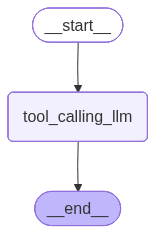

In [80]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
    
# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

If we pass in `Hello!`, the LLM responds without any tool calls.

In [81]:
messages = graph.invoke({"messages": HumanMessage(content="Hello!")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello!
================================== Ai Message ==================================

Hi there! How can I assist you today?


The LLM chooses to use a tool when it determines that the input or task requires the functionality provided by that tool.

In [82]:
messages = graph.invoke({"messages": HumanMessage(content="Multiply 2 and 3")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_l7xWV7UK6FN7lhItMmdCcqZZ)
 Call ID: call_l7xWV7UK6FN7lhItMmdCcqZZ
  Args:
    a: 2
    b: 3


# Tweaks


In [83]:
import os
from dotenv import load_dotenv
load_dotenv(dotenv_path="../module-1/studio/.env", override=True)

True

In [84]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(content=f"So you said you want to be a doctor?", name="Model")]
messages.append(HumanMessage(content=f"Yes, that's right.",name="Shambhavi"))
messages.append(AIMessage(content=f"Great, what would you like to learn about.", name="Model"))
messages.append(HumanMessage(content=f"I want to learn about the best medical colleges in India.", name="Shambhavi"))


for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you want to be a doctor?
================================ Human Message =================================
Name: Shambhavi

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Shambhavi

I want to learn about the best medical colleges in India.


In [85]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")
result = llm.invoke(messages)
type(result)

langchain_core.messages.ai.AIMessage

In [86]:
result

AIMessage(content='India is home to several prestigious medical colleges known for their quality education, research opportunities, and excellent faculty. Here are some of the best medical colleges in India:\n\n1. **All India Institute of Medical Sciences (AIIMS), New Delhi**: Often regarded as the top medical school in India, AIIMS New Delhi offers comprehensive medical education and is renowned for its state-of-the-art facilities and pioneering research.\n\n2. **Post Graduate Institute of Medical Education and Research (PGIMER), Chandigarh**: Known for its research-oriented programs, PGIMER offers various postgraduate and doctoral courses in medical and allied sciences.\n\n3. **Christian Medical College (CMC), Vellore**: CMC Vellore is acclaimed for its excellent education, research, and healthcare services, and has been a pioneer in medical education and development.\n\n4. **Jawaharlal Institute of Postgraduate Medical Education & Research (JIPMER), Puducherry**: An institution of n

In [87]:
result.response_metadata

{'token_usage': {'completion_tokens': 510,
  'prompt_tokens': 70,
  'total_tokens': 580,
  'completion_tokens_details': {'accepted_prediction_tokens': 0,
   'audio_tokens': 0,
   'reasoning_tokens': 0,
   'rejected_prediction_tokens': 0},
  'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}},
 'model_name': 'gpt-4o-2024-08-06',
 'system_fingerprint': 'fp_f64f290af2',
 'id': 'chatcmpl-CRHrEsUVNjBdvGgm3Ocdhcpx3rfyV',
 'service_tier': 'default',
 'finish_reason': 'stop',
 'logprobs': None}

In [88]:
def add(a: int, b: int) -> int:
    """Add a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

llm_with_tools = llm.bind_tools([add])

In [89]:
tool_call = llm_with_tools.invoke([HumanMessage(content=f"What is 2 added to 3", name="Lance")])

In [90]:
tool_call.tool_calls


[{'name': 'add',
  'args': {'a': 2, 'b': 3},
  'id': 'call_CI77gO2ehrW0JQDrpiS3GXfb',
  'type': 'tool_call'}]

In [91]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class MessagesState(TypedDict):
    messages: list[AnyMessage]

In [92]:
from typing import Annotated
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [93]:
from langgraph.graph import MessagesState

class MessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built 
    pass

In [94]:
# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on Human Anatomy.", name="Shambhavi")
                   ]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='465f0507-ad34-41d8-a07f-6fe477336cf0'),
 HumanMessage(content="I'm looking for information on Human Anatomy.", additional_kwargs={}, response_metadata={}, name='Shambhavi', id='8415925e-9c6e-4c43-9ebf-21710f7ae2af'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='4d6fba9b-49f0-4603-bfa3-d7bab5ffc984')]

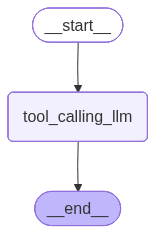

In [95]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
    
# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))